In [1]:
import math
import time
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

In [14]:
# Gaussian kernel
def Kernel(x, kernel_size) :
    return np.exp(-x**2 / kernel_size**2)

In [15]:
# Vector quantization algorithm
def QV(C, err, threshold, embedding_size, sample, current_error) :
    # compute minimum distance
    minimum = 1e100
    min_index = 0
    if (len(C) != 0) :
        min_index = np.argmin(abs(sample[embedding_size-1] - np.array(C)[:,embedding_size-1]))
        minimum = abs(sample[embedding_size-1] - np.array(C)[min_index,embedding_size-1])
    # update codebook
    if (minimum > threshold) :
        C.append(sample)
        err.append(current_error)
    else :
        err[min_index] += current_error
    return C, err

In [231]:
# Least Mean Squares filter 
def LMS_MSE(x, d, mu, K) :
    # calculate epochs
    epochs = np.size(x) - K
    # initialize vectors
    w = np.zeros(K)
    y = np.zeros(epochs)
    J = np.zeros(epochs)
    w_traces = np.zeros([epochs, K])
    # steepest descent
    for index in range(epochs) :
        # define window
        x_t = x[index:index+K]
        d_t = d[index+K-1]
        # stochastic gradient descent
        e = d_t - w.T@x_t
        w = w + mu*e*x_t
        y[index] = w.T@x_t
        # update J for learning curve
        J[index] = e**2
        # update weight traces
        w_traces[index,:] = w
    # return weights and learning curve
    return w, J, w_traces, y

class LMS_MCC():
    def __init__(self, step_size, order, sigma):
        self.step_size = step_size
        self.order = order
        self.sigma = sigma
        
    def learn(self, u, d):
        # initialize
        f = np.zeros(len(d))
        e = np.zeros(len(d))
        w = np.random.rand(self.order)
        w_trk = np.zeros((len(d)-self.order, self.order))
        # compute
        for i in range(1, len(d)-self.order):
            y = np.dot(w,u[i:i+self.order])
            e[i] = d[i+self.order] - y
            w = w + ((self.step_size / (np.sqrt(2 * np.pi) * self.sigma**3)) * np.exp(-e[i]**2 / (2 * self.sigma**2)) * e[i] * u[i])
            f[i] = y
            w_trk[i] = w 
        return f, w_trk, e
    
    def predict(self, u, d, w):
        # initialize
        f = np.zeros(len(d))
        e = np.zeros(len(d))
        # compute
        for i in range(1, len(d)-self.order):
            y = np.dot(w,u[i:i+self.order])
            e[i] = d[i+self.order] - y
            f[i] = y
        return f, e 

# QKLMS filter with MSE cost function
def QKLMS_MSE(x, d, kernel_size, embedding_size, step_size, threshold) :
    # calculate epochs
    epochs = np.size(x) - embedding_size
    # initialize vectors
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    a = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    err = []
    for i in range(epochs) :
        # compute output
        y[i] = 0
        x_vect = np.array(x[i:(i+embedding_size)])
        if (i != 0) :
            y[i] = step_size * np.array(err[0:i]).T @ Kernel(np.linalg.norm(x_vect - np.array(C), 2, axis=1), kernel_size)
        # update error
        e[i] = d[i+embedding_size-1] - y[i]
        # compute QV
        C, err = QV(C, err, threshold, embedding_size, x_vect, e[i])
        # update growth
        growth[i] = len(C)
    # return weights and learning curve
    return e**2, y, growth, step_size*np.array(err)

In [17]:
# QKLMS filter with MCC cost function
def QKLMS_MCC(x, d, kernel_size, entropy_kernel_size, embedding_size, step_size, threshold) :
    # calculate epochs
    epochs = np.size(x) - embedding_size
    # initialize vectors
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    a = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    err = []
    for i in range(epochs) :
        # compute output
        y[i] = 0
        x_vect = np.array(x[i:(i+embedding_size)])
        if (i != 0) :
            y[i] = step_size * (np.array(err[0:i]) * Kernel(np.array(err[0:i]), entropy_kernel_size)).T @ Kernel(np.linalg.norm(x_vect - np.array(C), 2, axis=1), kernel_size) / entropy_kernel_size**2
        # update error
        e[i] = d[i+embedding_size-1] - y[i]
        # compute QV
        C, err = QV(C, err, threshold, embedding_size, x_vect, e[i])
        # update growth
        growth[i] = len(C)
    # return weights and learning curve
    return e**2, y, growth, step_size*np.array(err)

In [18]:
# KRLS filter with MSE cost function
def QKRLS_MSE(x, d, regularizer, kernel_size, embedding_size, threshold) :
    # calculate epochs
    epochs = np.size(x) - embedding_size
    # initialize vectors
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    a = []
    Q = 0
    # iterate through samples
    for i in range(epochs) :
        # run QKRLS
        x_vect = x[i:(i+embedding_size)]
        if (i == 0) :
            Q = np.array([regularizer + Kernel(0, kernel_size)])**-1
            a = np.array([Q*d[0]])
            y[0] = 0
            C.append(x_vect)
        else :
            # compute QV
            minimum = 1e100
            min_index = 0
            if (len(C) != 0) :
                min_index = np.argmin(abs(x_vect[embedding_size-1] - np.array(C)[:,embedding_size-1]))
                minimum = abs(x_vect[embedding_size-1] - np.array(C)[min_index,embedding_size-1])
            # update codebook
            if (minimum > threshold) :
                C.append(x_vect)
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C)-1)]), 2, axis=1), kernel_size)]).T
                quantized = 1
            else :
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C))]), 2, axis=1), kernel_size)]).T
                quantized = 0
            # compute vectors
            z = np.array(Q@h)
            r = regularizer + Kernel(0, kernel_size) - z.T@h
            # update error
            y[i] = h.T@np.array(a)
            e[i] = d[i+embedding_size-1] - y[i]
            # compute output if quantized
            if (quantized == 1) :
                # update Q matrix
                Q_dim = len(z) + 1
                Q_t = np.zeros((Q_dim, Q_dim))
                Q_t[0:(Q_dim-1), 0:(Q_dim-1)] = r*Q + z@z.T
                Q_t[0:(Q_dim-1), (Q_dim-1):Q_dim] = -z
                Q_t[(Q_dim-1):Q_dim, 0:(Q_dim-1)] = -z.T
                Q_t[(Q_dim-1):Q_dim, (Q_dim-1):Q_dim] = 1
                Q = Q_t / r
                # update weights
                a_t = np.zeros((Q_dim,1))
                a_t[0:(Q_dim-1)] = a - z*e[i] / r
                a_t[(Q_dim-1):Q_dim] = e[i] / r
                a = a_t
            else :
                a[min_index] += e[i]
        # update growth curve
        growth[i] = len(C)
    return e**2, y, growth, a

In [19]:
# KRLS filter with MCC cost function
def QKRLS_MCC(x, d, regularizer, forgetting_factor, kernel_size, entropy_kernel_size, embedding_size, threshold) :
    # calculate epochs
    epochs = np.size(x) - embedding_size
    # initialize vectors
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    a = []
    Q = 0
    # iterate through samples
    for i in range(epochs) :
        # run QKRLS
        x_vect = x[i:(i+embedding_size)]
        if (i == 0) :
            Q = np.array([regularizer*(entropy_kernel_size**2)*forgetting_factor + Kernel(0, kernel_size)**-1])
            a = np.array([Q*d[0]])
            y[0] = 0
            C.append(x_vect)
        else :
            # compute QV
            minimum = 1e100
            min_index = 0
            if (len(C) != 0) :
                min_index = np.argmin(abs(x_vect[embedding_size-1] - np.array(C)[:,embedding_size-1]))
                minimum = abs(x_vect[embedding_size-1] - np.array(C)[min_index,embedding_size-1])
            # update codebook
            if (minimum > threshold) :
                C.append(x_vect)
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C)-1)]), 2, axis=1), kernel_size)]).T
                quantized = 1
            else :
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C))]), 2, axis=1), kernel_size)]).T
                quantized = 0
            # update error
            y[i] = h.T@np.array(a)
            e[i] = d[i+embedding_size-1] - y[i]
            # compute output if quantized
            if (quantized == 1) :
                # compute vectors
                z = np.array(Q@h)
                phi = Kernel(e[i], entropy_kernel_size)**-1
                r = regularizer*(entropy_kernel_size**2)*forgetting_factor + Kernel(0, kernel_size) - z.T@h
                # update Q matrix
                Q_dim = len(z) + 1
                Q_t = np.zeros((Q_dim, Q_dim))
                Q_t[0:(Q_dim-1), 0:(Q_dim-1)] = r*Q + z@z.T
                Q_t[0:(Q_dim-1), (Q_dim-1):Q_dim] = -z
                Q_t[(Q_dim-1):Q_dim, 0:(Q_dim-1)] = -z.T
                Q_t[(Q_dim-1):Q_dim, (Q_dim-1):Q_dim] = 1
                Q = Q_t / r
                # update weights
                a_t = np.zeros((Q_dim,1))
                a_t[0:(Q_dim-1)] = a - z*e[i] / r
                a_t[(Q_dim-1):Q_dim] = e[i] / r
                a = a_t
            else :
                a[min_index] += e[i]
        # update growth curve
        growth[i] = len(C)
    return e**2, y, growth, a

In [207]:
data = np.loadtxt("sun_spot_input.asc")
#series = np.array(data)
data = (data-min(data))/(max(data)-min(data))

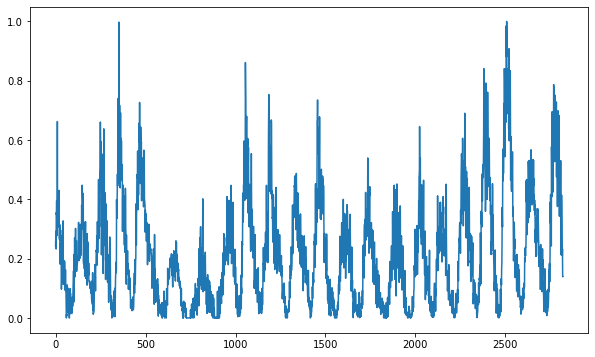

In [208]:
plt.figure(figsize=(10, 6))
plt.plot(data)

In [60]:
def compare_plot(predictions, target):
    t = [i for i in range(len(predictions))]
    plt.figure(figsize=(18, 5))
    plt.plot(t, target, label='Current')
    plt.plot(t, predictions, label='Delayed')
    plt.legend()
    plt.show()

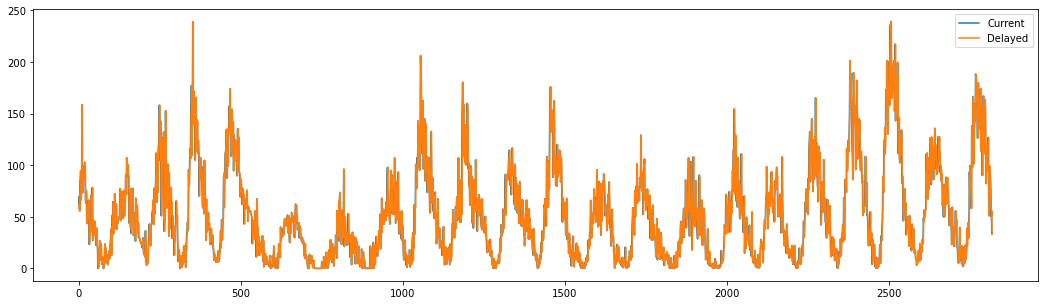

In [62]:
predictions = series[:-1]
compare_plot(predictions, series[1:])

In [241]:
x = data[0:200]
d = np.roll(x, 1)[0:200]

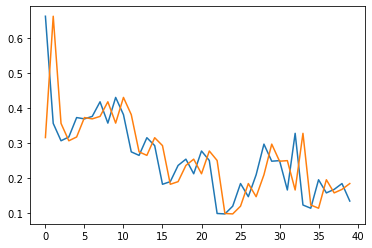

In [227]:
plt.plot(x[10:50])
plt.plot(d[10:50])

# LMS

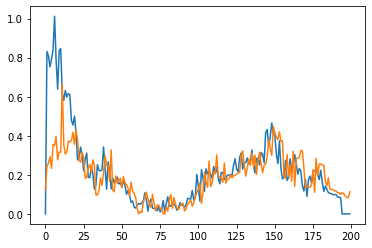

In [244]:
step_size = 0.1
order = 6
sigma = 0.7

lms = LMS_MCC(step_size, order, sigma)
outputs, weights, errors = lms.learn(x, d)
plt.plot(outputs)
plt.plot(d[0:200])

In [274]:
x = data
d = np.roll(x, 1)

outputs, errors = lms.predict(np.array([x[210]]), np.array([d[210]]), weights)
print(outputs)

[0.]


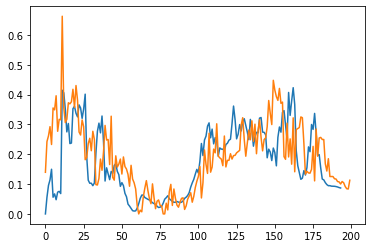

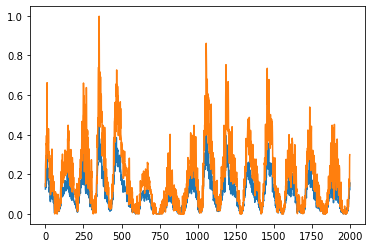

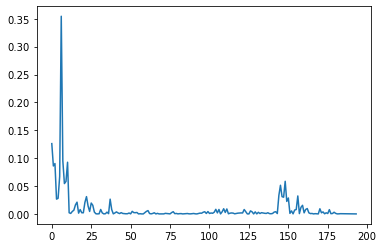

In [285]:
x = data[0:200]
d = np.roll(x, 1)[0:200]

regularizer = 0.01
embedding_size = 6
kernel_size = 0.3
entropy_kernel_size = 1
threshold = 0.3
forgetting_factor = 0.98
step_size = 0.2

J, y, growth, a = QKLMS_MSE(x, d, kernel_size, embedding_size, step_size, threshold)

x = data
d = np.roll(x, 1)

plt.plot(y)
plt.plot(d[0:200])
plt.show()

c = np.convolve(x, a.reshape(-1), mode='same')
plt.plot(c[0:2000])
plt.plot(d[0:2000])
plt.show()

plt.plot(J)
plt.show()

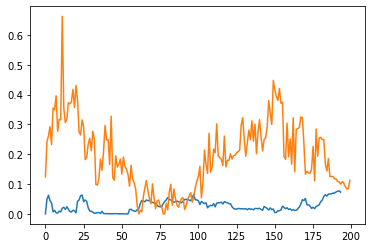

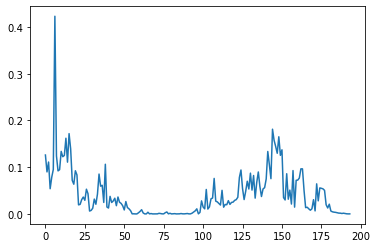

In [292]:
x = data[0:200]
d = np.roll(x, 1)[0:200]

regularizer = 0.01
embedding_size = 6
kernel_size = 0.3
entropy_kernel_size = 1
threshold = 0.1
forgetting_factor = 0.98
step_size = 0.2

J, y, growth, a = QKLMS_MCC(x, d, kernel_size, entropy_kernel_size, embedding_size, step_size, threshold)
plt.plot(y)
plt.plot(d[0:200])
plt.show()

plt.plot(J)
plt.show()

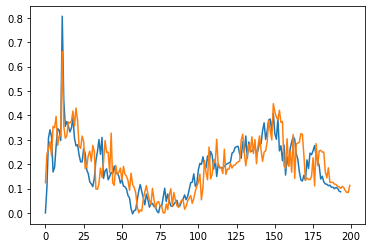

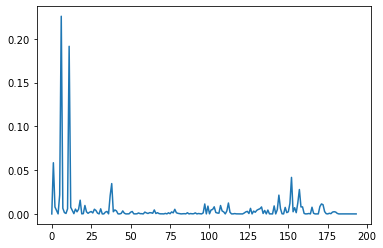

In [265]:
x = data[0:200]
d = np.roll(x, 1)[0:200]

regularizer = 0.01
embedding_size = 6
kernel_size = 0.4
entropy_kernel_size = 1
threshold = 0.3
forgetting_factor = 0.98
step_size = 0.2

J, y, growth, a = QKRLS_MSE(x[0:200], d[0:200], regularizer, kernel_size, embedding_size, threshold)
plt.plot(y)
plt.plot(d[0:200])
plt.show()

plt.plot(J)
plt.show()

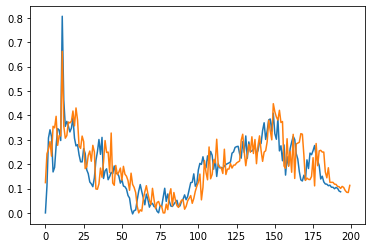

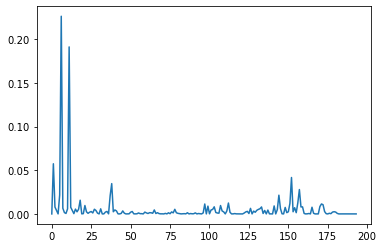

In [269]:
x = data[0:200]
d = np.roll(x, 1)[0:200]

regularizer = 0.01
embedding_size = 6
kernel_size = 0.4
entropy_kernel_size = 1
threshold = 0.3
forgetting_factor = 0.98
step_size = 0.2

J, y, growth, a = QKRLS_MCC(x[0:200], d[0:200], regularizer, forgetting_factor, kernel_size, entropy_kernel_size, embedding_size, threshold)
plt.plot(y)
plt.plot(d[0:200])
plt.show()

plt.plot(J)
plt.show()